In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import xarray as xr
from scipy import signal
import nclcmaps 
import regression_analysis as rig
from scipy import stats
cmap1 = nclcmaps.cmap('BlueWhiteOrangeRed')

In [2]:
# %store -z

In [3]:
%store -r df_567_all
%store -r df_567_all_3yr
%store -r amp1_wh04_filt 
%store -r phase1_wh04_filt

## 1. functions for regression

In [9]:
def smooth(x,window_len=11,window='hanning'):
    ##https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
        
    example:
    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[window_len//2:-window_len//2]



def lowpass_scipy_butter(signal1,wn,lt):
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal



def regress(y,x,cor_type='spearmanr',opt='running'):    
    
    wn=3;lf=10;window_len=3
    x = signal.detrend(x)
    
    if any(np.isnan(y)):
        r = np.nan
    else:
        y = signal.detrend(y)
        
        if opt=='running':
            x = smooth(x,window_len,window='flat')
            y = smooth(y,window_len,window='flat')
        elif opt == 'lowpass':
            x= lowpass_scipy_butter(x,wn,lf)
            y= lowpass_scipy_butter(y,wn,lf)
        elif opt == 'original':
            x = x*1
            y = y*1
            
        if cor_type=='spearmanr':
            r,p = stats.spearmanr(x,y)
        elif cor_type=='pearsonr' :
            _, _, r, p,_ = stats.linregress(x,y)
            
        if p<0.05:
            r = np.nan
    return r
    
def running_correlation(y,x,k,cor_type='spearmanr'):
    run_cor = np.zeros(len(y)-k)
    run_cor.fill(np.nan)
    
    
    for i in np.arange(len(y)-k):
        x1= x[i:i+k]
        y1= y[i:i+k]
        if any(np.isnan(y1)):
            run_cor[i] =  np.nan
        else:
            x1 = signal.detrend(x1)
            y1 = signal.detrend(y1)
            if cor_type=='spearmanr':
                r,p = stats.spearmanr(x,y) 
            elif cor_type=='pearsonr' :
                r = np.corrcoef(x1,y1)[0,1]
            run_cor[i] = r*1
            
    return run_cor

In [10]:
def cor_map(AA,variable,time_series,s1,s2,sub_no,cor_type='pearsonr',opt='original'):

    AA1 = AA[variable]
    BB = np.apply_along_axis(regress,axis=0,arr = AA1.values,x=time_series,cor_type=cor_type,opt=opt)
    ds      =   xr.Dataset({variable: (('lat','lon'), BB)}, coords={'lat': lat,'lon': lon})
    
    
    ax = plt.subplot(s1,s2,sub_no,projection=ccrs.PlateCarree(central_longitude=180.0))

    cs= ds[variable].plot(ax=ax,transform = ccrs.PlateCarree(), levels=  np.arange(-0.5,0.55,0.05), cmap=cmap1,
        add_colorbar=False, extend='both')
    
    ax.contour(lon,lat,ds[variable].values,levels=[-0.3,0.3], linewidths=0.5, colors='black', antialiased=True,transform = ccrs.PlateCarree())
    ax.coastlines()

    ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    ax.set_yticks([-60,-45,-30,-15, 0, 15, 30,45,60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    cbar =  plt.colorbar(cs, shrink=0.5, orientation='horizontal',extend='both')

def time_cor(AA,varaible,time_series,window,opt,ax,cor_type='spearmanr'):
    if opt ==1:
        AA1 = AA.sel(lat=slice(-25,25)).mean(dim='lat')
    else:
        AA1 = AA.sel(lat=slice(25,-25)).mean(dim='lat')
    
    AA11 = AA1[variable]*1

    time1 = AA11.time[:len(time_series)-window]
    
    BB = np.apply_along_axis(running_correlation,axis=0,arr = AA11.values,x=time_series,k=window,cor_type=cor_type)
   
        
    cf = ax.contourf(lon,time1.values,BB,cmap=cmap1,levels=[-0.5,-0.40,-0.30,-0.2,-0.1,0.1,0.2,0.30,0.40,0.5],extend ='both')
    
    ax.contour(lon,time1.values,BB,levels=[-1*0.40,0.40],colors='black', linewidths=0.5,antialiased=True)
    ax.invert_yaxis()
    cbar = plt.colorbar(cf,ax=ax,orientation='horizontal',fraction=0.05)



## winter HADISST time series conv

In [6]:
file_name =  'sst_raw_nov_apr_1905-2015_hadisst.nc'
AA = xr.open_dataset(file_name)
lat = AA.lat
lon = AA.lon

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(15,8))
# variable='sst';time_series = df_567_all.iloc[:,0].values
# cor_map(AA,variable,time_series,1,2,1,cor_type='spearmanr',opt='original')
# time_cor(AA,variable,time_series,window=20,opt=1,ax=ax[1],cor_type='spearmanr')

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(15,8))
# variable='sst';time_series = df_567_all.iloc[:,1].values
# cor_map(AA,variable,time_series,1,2,1,opt='original')
# time_cor(AA,variable,time_series,window=20,opt=1,ax=ax[1])


In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(15,8))
# variable='sst';time_series = df_567_all.iloc[:,3].values
# cor_map(AA,variable,time_series,1,2,1,opt='original')
# time_cor(AA,variable,time_series,window=20,opt=1,ax=ax[1])

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(15,8))
# variable='sst';time_series = df_567_all.iloc[:,4].values
# cor_map(AA,variable,time_series,1,2,1,opt='original')
# time_cor(AA,variable,time_series,window=20,opt=1,ax=ax[1])

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
variable='sst';time_series = df_567_all.iloc[:,5].values
cor_map(AA,variable,time_series,1,2,1,cor_type='pearsonr',opt='original')
time_cor(AA,variable,time_series,window=20,opt=1,ax=ax[1],cor_type='pearsonr')

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
variable='sst'
st1= 1980 ;en1 =2015
time_series = df_567_all.loc[str(st1)+'-12-31':str(en1)+'-12-31'].iloc[:,2]
AA1= AA.sel(time=slice(str(st1)+'-01-01',str(en1)+'-12-31'))
cor_map(AA1,variable,time_series,1,2,1,cor_type='pearsonr',opt='original')
time_cor(AA1,variable,time_series,window=30,opt=1,ax=ax[1],cor_type='pearsonr')

## known period

In [11]:
st1 = 1921; en1  = 1944 
st2 = 1945; en2  = 1976
st3 = 1980; en3  = 2015
st4 = 1980; en4  = 2015


AA4 =  AA.sel(time=slice(str(st4)+'-01-01',str(en4)+'-12-31'))
AA4

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 120, lon: 360, time: 36)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31T06:00:00 ... 2015-02-01
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sst        (time, lat, lon) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.9.5 (http://...
    Conventions:                CF-1.0
    history:                    Sun Mar 01 12:49:48 2020: cdo mergetime mean1...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.9.5 (http://...

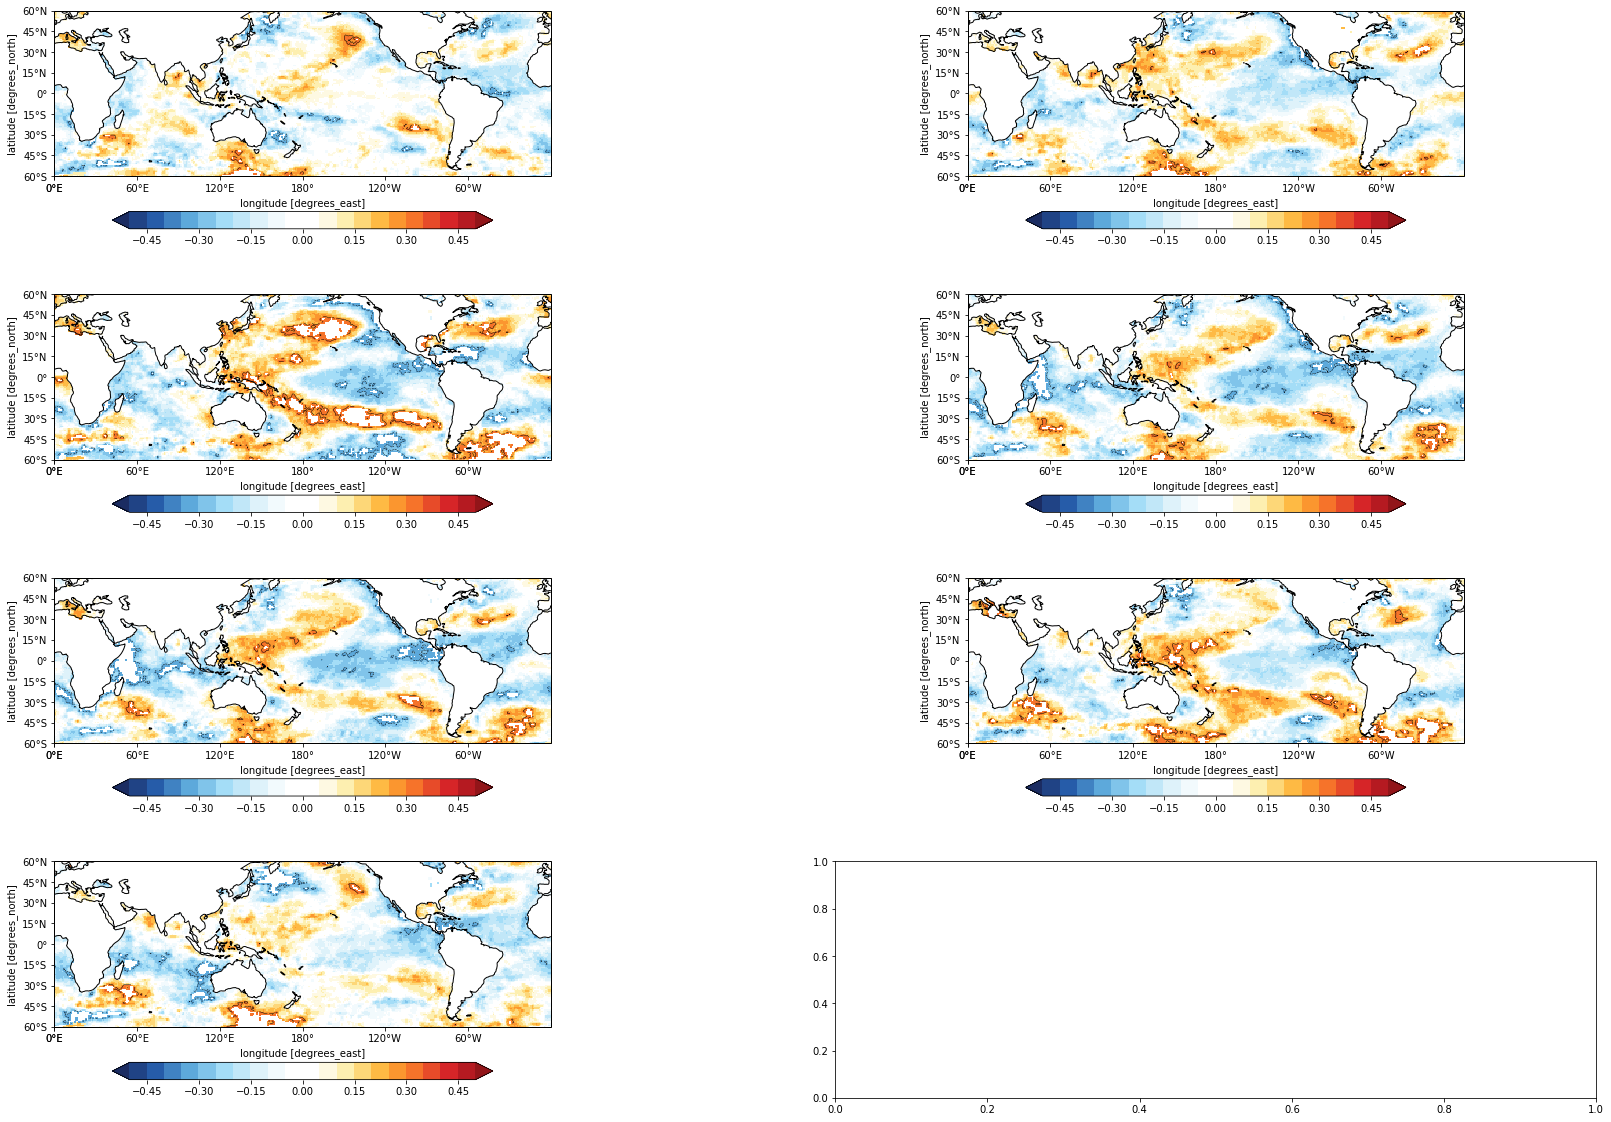

In [12]:
fig,ax = plt.subplots(4,2,figsize=(30,20))
variable='sst'

cor_map(AA4,variable,df_567_all.loc[str(st4)+'-12-31':str(en4)+'-12-31'].iloc[:,0],4,2,1,cor_type='spearmanr',opt='original')
cor_map(AA4,variable,df_567_all.loc[str(st4)+'-12-31':str(en4)+'-12-31'].iloc[:,1],4,2,2,cor_type='spearmanr',opt='original')
cor_map(AA4,variable,df_567_all.loc[str(st4)+'-12-31':str(en4)+'-12-31'].iloc[:,2],4,2,3,cor_type='spearmanr',opt='original')
cor_map(AA4,variable,df_567_all.loc[str(st4)+'-12-31':str(en4)+'-12-31'].iloc[:,3],4,2,4,cor_type='spearmanr',opt='original')
cor_map(AA4,variable,df_567_all.loc[str(st4)+'-12-31':str(en4)+'-12-31'].iloc[:,4],4,2,5,cor_type='spearmanr',opt='original')
cor_map(AA4,variable,df_567_all.loc[str(st4)+'-12-31':str(en4)+'-12-31'].iloc[:,5],4,2,6,cor_type='spearmanr',opt='original')
cor_map(AA4,variable,df_567_all.loc[str(st4)+'-12-31':str(en4)+'-12-31'].iloc[:,6],4,2,7,cor_type='spearmanr',opt='original')


In [ ]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
file_name = 'MSE_raw_nov_apr_1979-2015_20CRV3.nc';variable='MSE_vint'

cor_map(file_name,variable,t567_conv_hist_curent,3,2,1,opt='original')
cor_map(file_name,variable,t567_ol_hist_curent,3,2,2,opt='original')
cor_map(file_name,variable,t567_mlr_hist_curent,3,2,3,opt='original')
cor_map(file_name,variable,t567_wh04[:],3,2,4,opt='original')
# cor_map(file_name,variable,t567_conv_hist_curent2d,3,2,6,opt='original')


In [ ]:
ds = xr.open_dataset('MSE_raw_nov_apr_1979-2015_ncepII.nc')

In [ ]:
t567_conv_hist_curent = t567_conv_hist[-37:-1]
t567_ol_hist_curent = t567_ol_hist[-37:-1]
t567_mlr_hist_curent = t567_mlr_hist[-37:-1]
t567_conv_hist_curent2d = t567_svr_hist[-37:-1]


fig,ax = plt.subplots(2,2,figsize=(20,20))
file_name = 'MSE_raw_nov_apr_1979-2015_ncepII.nc';variable='MSE_vint'

cor_map(file_name,variable,t567_conv_hist_curent,3,2,1,opt='original')
cor_map(file_name,variable,t567_ol_hist_curent,3,2,2,opt='original')
cor_map(file_name,variable,t567_mlr_hist_curent,3,2,3,opt='original')
# cor_map(file_name,variable,t567_conv_hist_curent2d,3,2,6,opt='original')


In [ ]:
cor_map(file_name,variable,t567_wh04[:],3,2,4,opt='original')


In [ ]:
np.corrcoef(df_567_all.iloc[:,0],df_567_all.iloc[:,4])

In [ ]:
AA = xr.open_dataset('MSE_raw_nov_apr_1905-2014_20CRV2_wotrend.nc')

# lat = AA.lat
# lon = AA.lon

pos_first = AA.sel(time=slice("1924-01-01","1946-12-31")).mean(dim = 'time')
neg_first = AA.sel(time=slice("1947-01-01","1976-12-31")).mean(dim = 'time')
pos_second = AA.sel(time=slice("1977-01-01","1999-12-31")).mean(dim = 'time')
neg_second = AA.sel(time=slice("2000-01-01","2014-12-31")).mean(dim = 'time')
pos_first

In [ ]:
 AA.sel(lat=slice(0,-5),lon=slice(150,155)).mean(dim = 'lat').mean(dim='lon').MSE_vint.plot()

In [ ]:
AA.sel(lat=slice(0,-5),lon=slice(150,155)).mean(dim = 'lat').mean(dim='lon').MSE_vint

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
pos_first['MSE_vint'].plot(ax=ax)
ax.coastlines()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
neg_first['MSE_vint'].plot(ax=ax,transform = ccrs.PlateCarree(), cmap=cmap1,
        add_colorbar=True, extend='both')
ax.coastlines()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
pos_second['MSE_vint'].plot(ax=ax,transform = ccrs.PlateCarree(), cmap=cmap1,
        add_colorbar=True, extend='both')
ax.coastlines()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
neg_second['MSE_vint'].plot(ax=ax,transform = ccrs.PlateCarree(), cmap=cmap1,
        add_colorbar=True, extend='both')
ax.coastlines()
ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_yticks([-90,-75,-60,-45,-30,-15, 0, 15, 30,45,60,75,90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


## winter skin temp giss

In [ ]:
AA = xr.open_dataset('skt_raw_nov_apr_1905-2015_giss.nc')

lat = AA.lat
lon = AA.lon

AA1 = AA['air']
BB = np.apply_along_axis(regress,axis=0,arr = AA1.values,x=t567_conv_hist,opt='running')
ds      =   xr.Dataset({'skt': (('lat','lon'), BB)}, coords={'lat': lat,'lon': lon})

fig,ax = plt.subplots(1,1,figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ds.skt.plot(ax=ax,transform = ccrs.PlateCarree(), levels=  np.arange(-0.5,0.55,0.05), cmap=cmap1,
        add_colorbar=True, extend='both')
ax.contour(lon,lat,ds.skt.values,levels=[-1*0.18,0.18], linewidths=0.5, colors='black', antialiased=True,transform = ccrs.PlateCarree())
ax.coastlines()

ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_yticks([-90,-75,-60,-45,-30,-15, 0, 15, 30,45,60,75,90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


## Skin temperature 20CRV3

In [ ]:
AA = xr.open_dataset('skt_raw_nov_apr_1905-2015_20CRv3.nc')

lat = AA.lat
lon = AA.lon

AA1 = AA['skt']
BB = np.apply_along_axis(regress,axis=0,arr = AA1.values,x=t567_conv_hist,opt='running')
ds      =   xr.Dataset({'skt': (('lat','lon'), BB)}, coords={'lat': lat,'lon': lon})
fig,ax = plt.subplots(1,1,figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ds.skt.plot(ax=ax,transform = ccrs.PlateCarree(), levels=  np.arange(-0.5,0.55,0.05), cmap=cmap1,
        add_colorbar=True, extend='both')
ax.contour(lon,lat,ds.skt.values,levels=[-1*0.18,0.18], linewidths=0.5, colors='black', antialiased=True,transform = ccrs.PlateCarree())
ax.coastlines()

ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_yticks([-90,-75,-60,-45,-30,-15, 0, 15, 30,45,60,75,90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

In [ ]:
## MSE 
AA = xr.open_dataset('MSE_raw_nov_apr_1979-2014_20CRV2.nc')

lat = AA.lat
lon = AA.lon

AA1 = AA['MSE_vint']
BB = np.apply_along_axis(regress,axis=0,arr = AA1.values,x=t567_wh04[:-1],opt='original')
ds      =   xr.Dataset({'skt': (('lat','lon'), BB)}, coords={'lat': lat,'lon': lon})
fig,ax = plt.subplots(1,1,figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ds.skt.plot(ax=ax,transform = ccrs.PlateCarree(), levels=  np.arange(-0.5,0.55,0.1), cmap=cmap1,
        add_colorbar=True, extend='both')
ax.contour(lon,lat,ds.skt.values,levels=[-1*0.3,0.3], linewidths=0.5, colors='black', antialiased=True,transform = ccrs.PlateCarree())
ax.coastlines()

ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_yticks([-90,-75,-60,-45,-30,-15, 0, 15, 30,45,60,75,90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

In [ ]:
AA = xr.open_dataset('MSE_raw_nov_apr_1905-2014_20CRV2.nc')
AA.MSE_vint.values = AA['MSE_vint'].values/10000
AA1 = AA.sel(lat=slice(20,-20)).mean(dim='lat')

AA11 = AA1['MSE_vint']
time1 = AA11.time[:len(t567_conv_hist)-20-1]
lon = AA11.lon
BB = np.apply_along_axis(running_correlation,axis=0,arr = AA11.values,x=t567_conv_hist[:-1],k=20)
print(BB.shape)

plt.figure(1, figsize=(6, 6)) # Figure size in inches (size_x, size_y)
plt.contourf(lon,time1.values,BB,cmap=cmap1,levels=[-0.50,-0.40,-0.30,-0.2,-0.1,0.1,0.2,0.30,0.40,0.50],extend ='both')
plt.colorbar()

plt.contour(lon,time1.values,BB,levels=[-1*0.4,0.4],colors='black', linewidths=0.5,antialiased=True)

plt.gca().invert_yaxis()
BB.shape,time1.shape,lon.shape

In [ ]:
plt.plot(running_correlation(t123_conv_hist,t567_conv_hist,20))